In [1]:
import jupyter

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym

from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import skew, kurtosis, entropy
from statsmodels.stats.diagnostic import acorr_ljungbox

from src.utils.system import boot
from src.defaults import RANDOM_SEEDS, TOP2_STOCK_BY_SECTOR
from tracker import OHLCV_DF, EpisodeTracker, EnvironmentTracker, AgentTracker



In [3]:
# Configuration ======================
excluded_tickers = sorted(['CEG', 'GEHC', 'GEV', 'KVUE', 'SOLV'])

config = {
    "regressor": "RandomForestRegressor",
    "n_estimators": 300,
    "random_state": 314,
    "transaction_cost": 0
}

run_settings = {
    "excluded_tickers": excluded_tickers,
    "min_samples": 10,
    "cv_folds": 3,
    "lags": 5,
    "start_date": "2023-12-31",
    "end_date": "2025-05-01",
    "seed": 314,
    "episode_length": 50,
    "noise_feature_cols": ["return_1d", "volume"],
    "train_steps": 50_000,
    "lookback": 0,
    
}

# System Boot =======================
DEVICE = boot()



In [4]:
# Helper functions ====================
import numpy as np

def compute_returns_curve(curve):
    returns = np.diff(curve) / curve[:-1]
    return returns

def sharpe_ratio(returns, risk_free_rate=0.0):
    excess = returns - risk_free_rate
    return np.mean(excess) / (np.std(excess) + 1e-8)

def sortino_ratio(returns, risk_free_rate=0.0):
    returns = np.array(returns)
    excess = returns - risk_free_rate
    downside = excess[excess < 0]
    
    # Avoid division by zero: if no downside, assume very small downside deviation
    if len(downside) == 0:
        downside_std = 1e-8
    else:
        downside_std = np.std(downside)
    
    return np.mean(excess) / downside_std


def calmar_ratio(returns_curve):
    total_return = returns_curve[-1] / returns_curve[0] - 1
    drawdown = np.maximum.accumulate(returns_curve) - returns_curve
    max_drawdown = np.max(drawdown) / returns_curve[0]
    return total_return / (max_drawdown + 1e-8)

def central_tendency_difference (mean,median,std):
    return abs(mean-median)/(abs(std))

In [125]:
import os
import json
import hashlib
from collections import defaultdict
STORAGE_PATH = "data/experiments/episode_benchmark_engine/runs.csv"


EXCLUDED_TICKERS = sorted(["CEG", "GEHC", "GEV", "KVUE", "SOLV"])

CONFIG = {
    "regressor": "RandomForestRegressor",
    "n_estimators": 300,
    "random_state": 314,
    "transaction_cost": 0,
}
LOOKBACK = 0
EPISODE_LENGTH = 50

RUN_SETTINGS = {
    "excluded_tickers": EXCLUDED_TICKERS,
    "cv_folds": 3,
    "lags": 5,
    "seed": 314,
    'total_timesteps':50_000,
    "episode": {
        "episode_length": EPISODE_LENGTH,
        "lookback": LOOKBACK,
    },
    "environment": {
        "market_features": ["close", "price_change", "volume_change"],
        "version": "v2",
        "lookback": LOOKBACK,
        "episode_length": EPISODE_LENGTH,
        "transaction_cost": 0,
    },
    "agent": {
        "model_class": "PPO",
        "policy_class": "MlpPolicy",
        "config": {
            "verbose": 1,
            "ent_coef":0.1,
            "policy_kwargs": 
                {
                
                    "net_arch": [64, 64]
                    }
                },
    },
}


class EpisodeBenchmark:
    def __init__(
        self,
        tickers=["AAPL"],
        config=CONFIG,
        run_settings=RUN_SETTINGS,
        start_date="2024-01-01",
    ):
        self.ohlcv_df = OHLCV_DF.copy()
        self.tickers = tickers  # Force test with AAPL
        self.start_date = start_date


        self.config = CONFIG.copy()
        self.config.update(config)
        
        self.run_settings = RUN_SETTINGS.copy()
        self.run_settings.update(run_settings)
        self.run_settings['environment']['market_features'].sort()
        
        self.ep_tracker = EpisodeTracker()
        self.env_tracker = EnvironmentTracker()
        self.agent_tracker = AgentTracker()
        
        self.boot()
        
    def boot(self):
        if os.path.exists(STORAGE_PATH):
            self.completed_runs_df = pd.read_csv(STORAGE_PATH)

            self.completed_hashes = set(self.completed_runs_df["run_hash"].unique())
            self.seen_seeds = defaultdict(set)
            for _, row in self.completed_runs_df.iterrows():
                self.seen_seeds[row["run_hash"]].add(row["seed"])
        else:
            self.completed_runs_df = pd.DataFrame()
            self.completed_hashes = set()
            self.seen_seeds = defaultdict(set)

    def compute_run_hash(self, agent_id, train_episode_id,train_environment_id):
        market_features =self.run_settings['environment']['market_features']
        market_features.sort()
        payload = {
            "agent_id": agent_id,
            "episode_id": train_episode_id,
            "environment_id":train_environment_id,
            "timesteps": self.run_settings['total_timesteps'],
            "lookback":self.run_settings['episode']['lookback'],
            "episode_length":self.run_settings['episode']['episode_length'],
            "market_features":json.dumps(market_features)
        }
        return hashlib.md5(json.dumps(payload, sort_keys=True).encode()).hexdigest()
    
    def extract_agent_diagnostics(self,env, model, mode="train"):
        """
        Runs agent through environment and extracts residual diagnostics
        from reward trajectory, wallet progression, and optionally oracle and market.
        """
        rewards = []
        residuals_oracle = []
        obs = env.reset()[0]
        done = False

        oracle_progress = []
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(action)
            rewards.append(reward)

            # Oracle fallback
            oracle_score = info.get("oracle_score", None)
            if oracle_score is not None:
                oracle_progress.append(oracle_score)
                residuals_oracle.append(oracle_score - reward)
            else:
                oracle_progress.append(abs(reward))

        # Agent vs Oracle residuals
        if residuals_oracle:
            r_oracle = np.array(residuals_oracle)
        else:
            smoothed = pd.Series(rewards).rolling(window=5, min_periods=1).mean()
            r_oracle = np.array(rewards) - smoothed.values

        # Agent vs Market residuals
        agent_returns = np.array(env.wallet_progress)
        market_returns = np.array(env.market_progress)
        r_market = agent_returns - market_returns

        # Daily returns
        returns = pd.Series(agent_returns).pct_change().dropna().values
        market_pct_returns = pd.Series(market_returns).pct_change().dropna().values

        diagnostics = {
            f"{mode}_total_reward": env.total_reward,
            f"{mode}_wallet":env.wallet,
            f"{mode}_market":env.market_progress[-1],

            # Residuals vs Oracle
            f"{mode}_resid_oracle_std": np.std(r_oracle),
            f"{mode}_resid_oracle_skew": skew(r_oracle),
            f"{mode}_resid_oracle_kurtosis": kurtosis(r_oracle),
            f"{mode}_resid_oracle_acf1": pd.Series(r_oracle).autocorr(lag=1),
            f"{mode}_resid_oracle_mean": np.mean(r_oracle),
            f"{mode}_resid_oracle_median": np.median(r_oracle),
            f"{mode}_resid_oracle_max": np.max(r_oracle),
            f"{mode}_resid_oracle_min": np.min(r_oracle),
            f"{mode}_ljung_oracle_pval": (
                acorr_ljungbox(r_oracle, lags=[min(10, len(r_oracle) - 1)], return_df=True).iloc[0]['lb_pvalue']
                if len(r_oracle) > 10 else np.nan
            ),

            # Residuals vs Market
            f"{mode}_resid_market_std": np.std(r_market),
            f"{mode}_resid_market_skew": skew(r_market),
            f"{mode}_resid_market_kurtosis": kurtosis(r_market),
            f"{mode}_resid_market_acf1": pd.Series(r_market).autocorr(lag=1),
            f"{mode}_resid_market_mean": np.mean(r_market),
            f"{mode}_resid_market_median": np.median(r_market),
            f"{mode}_resid_market_max": np.max(r_market),
            f"{mode}_resid_market_min": np.min(r_market),
            f"{mode}_ljung_market_pval": (
                acorr_ljungbox(r_market, lags=[min(10, len(r_market) - 1)], return_df=True).iloc[0]['lb_pvalue']
                if len(r_market) > 10 else np.nan
            ),

            # Financial performance
            f"{mode}_sharpe": sharpe_ratio(returns),
            f"{mode}_sortino": sortino_ratio(returns),
            f"{mode}_calmar": calmar_ratio(agent_returns),
            f"{mode}_market_sharpe": sharpe_ratio(market_pct_returns),
            f"{mode}_market_sortino": sortino_ratio(market_pct_returns),
            f"{mode}_market_calmar": calmar_ratio(market_returns),
        }

        return diagnostics


    def correlation_with_test_result(self,test_result_feature="test_total_reward"):
        pddf = self.completed_runs_df.copy()
        
        cols_to_drop = [col for col in pddf.columns if col.startswith('test_') and col != test_result_feature]
        pddf_cleaned = pddf.drop(columns=cols_to_drop)

        correlations = pddf_cleaned.corr(numeric_only=True)[test_result_feature].sort_values(ascending=False)
        
        return correlations
    
    def describe(self, feature =None):
        descriptions = {
            "resid_mean": 
                "Mean of the residuals between agent and oracle/market.\n"
                "- Ideal: Close to 0 (no bias).\n"
                "- Positive: agent tends to overperform the benchmark.\n"
                "- Negative: consistent underperformance.",

            "resid_std": 
                "Standard deviation of residuals (volatility of difference).\n"
                "- Ideal: Low (stable excess performance).\n"
                "- High: unstable or noisy relative performance.",

            "resid_acf1": 
                "Autocorrelation at lag 1 of residuals.\n"
                "- Ideal: Close to 0 (no pattern).\n"
                "- Positive: persistent patterns (possibly exploitable).\n"
                "- Negative: mean-reverting behavior.",

            "resid_min": 
                "Minimum residual — worst case vs benchmark.\n"
                "- Ideal: Not too negative.\n"
                "- Negative: large underperformance at some point.",

            "resid_max": 
                "Maximum residual — best case vs benchmark.\n"
                "- Ideal: High (agent strongly beats the benchmark).",

            "resid_skew": 
                "Skewness of residual distribution.\n"
                "- Ideal: Slightly positive (more upside extremes).\n"
                "- Negative: heavier downside risks.",

            "resid_kurtosis": 
                "Kurtosis of residuals — fat tails.\n"
                "- Ideal: Moderate (3 is normal).\n"
                "- High: rare but extreme performance differences.",

            "resid_ljung_pval": 
                "Ljung-Box test p-value for autocorrelation in residuals.\n"
                "- Ideal: > 0.05 (no significant autocorrelation).\n"
                "- Low: residuals have autocorrelation (potential inefficiency).",

            "sharpe": 
                "Sharpe ratio — risk-adjusted return.\n"
                "- Ideal: High (>1 good, >2 excellent).\n"
                "- Negative: losing money or volatile with low return.",

            "sortino": 
                "Sortino ratio — like Sharpe but penalizes only downside risk.\n"
                "- Ideal: High (>1).\n"
                "- More robust than Sharpe when upside is volatile.",

            "calmar": 
                "Calmar ratio — return / max drawdown.\n"
                "- Ideal: High (>1).\n"
                "- Penalizes deep losses more than volatility-based ratios.",
        }
        if feature !=None:
            print(descriptions.get(feature, "No description available for this feature."))
        else:
            for k,v in descriptions.items():
                print(v)
                print('')
                
    def run(self, tickers=None):
        # Configurations =============================
        config = self.config
        run_settings = self.run_settings

        # Feature Extraction Loop ====================
        features, targets, metadata, runs = [], [], [], []
        ohlcv_df = self.ohlcv_df.copy()

        if tickers == None:
            tickers = self.tickers
        
        seed = 314
        boot(seed)
        
        for symbol in tqdm(tickers):
            df = ohlcv_df[ohlcv_df["symbol"] == symbol].sort_values("date").copy()
            df = df[df["date"] > self.start_date]
            df = df.iloc[: -self.run_settings["episode"]["episode_length"]]
            months = df["month"].unique()
            
            for i  in range(len(months)):
                try:

                    target_date = str(months[i]) + "-01"
                    
                    episodes = self.ep_tracker.findEpisode(
                        target_date,
                        symbol,
                        episode_length=self.run_settings["episode"]["episode_length"],
                        lookback=self.run_settings["episode"]["lookback"],
                        mode="both",
                    )

                    train_episode = episodes["train"]
                    test_episode = episodes["test"]

                    env_tracker = EnvironmentTracker()

                    train_env_config = {
                        "ticker": symbol,
                        "n_timesteps": self.run_settings["episode"]["episode_length"],
                        "lookback": self.run_settings["episode"]["lookback"],
                        "market_features":self.run_settings['environment']['market_features'],
                        "seed": seed,
                        "start_idx": train_episode["df_start_iloc"],  # type: ignore
                    }
                    test_env_config = train_env_config.copy()
                    test_env_config["start_idx"] = test_episode["df_start_iloc"] # type: ignore

                    env_info = env_tracker.findEnvironment(
                        version=self.run_settings['environment']['version'], config=train_env_config
                    )
                    
                    train_env = env_info["environment"]
                    #train_config["start_idx"] = test_episode["start_idx"]
                    
                    test_env = env_tracker.findEnvironment(
                        version=self.run_settings['environment']['version'], config=test_env_config
                    )
                   
                    test_env = test_env["environment"]

                    tracker = AgentTracker()
                    
                    agent = tracker.findAgent(
                        **self.run_settings['agent']
                   
                    )
                    
                    run_hash = self.compute_run_hash(
                        agent_id=agent["id"],
                        train_episode_id=train_episode["id"],
                        train_environment_id=env_info['id']
                    )
                    
                    if run_hash in self.completed_hashes and seed in self.seen_seeds[run_hash]:
                        
                        continue  # Skip
                    print('will run',run_hash)    
                    _model = agent["model"].boot(train_env)
                    _model.learn(total_timesteps=self.run_settings['total_timesteps'])
                    
                    # diagnostics 
                     
                    train_diagnostics =self.extract_agent_diagnostics(train_env,_model,mode="train")
                    test_diagnostics =self.extract_agent_diagnostics(test_env,_model,mode="test")
                    full_diagnostics = {
                        **train_diagnostics,
                        **test_diagnostics
                    }
                    #ddf.append(full_diagnostics)
                    results =  {
                        'run_hash':run_hash,
                        'seed':seed,
                        'target_date':target_date,
                            "agent":self.run_settings['agent']['model_class'],
                            "policy":self.run_settings['agent']['policy_class'],
                            "env_version":env_info['version'],
                            "train_episode_id": train_episode["id"],
                            "test_episode_id":  test_episode["id"],
                            "total_timesteps": self.run_settings['total_timesteps'],
                            "ticker": symbol,
                            "target_date": target_date,
                            "environment_id": env_info["id"],
                            "agent_id": agent["id"],
                            "episode_length":self.run_settings['episode']['episode_length'],
                            "lookback":self.run_settings['episode']['lookback'],
                            "market_features":json.dumps(self.run_settings['environment']['market_features']),
                            **full_diagnostics
                        }
                    if run_hash in self.completed_hashes and seed in self.seen_seeds[run_hash]:
                        print(f"Skipping already completed run {run_hash} with seed {seed}")
                    else:
                        self.completed_runs_df = pd.concat([self.completed_runs_df, pd.DataFrame([results])], ignore_index=True)
                        self.completed_hashes.add(run_hash)
                        self.seen_seeds[run_hash].add(seed)
                        self.completed_runs_df.to_csv(STORAGE_PATH,index=False)

                    # runs.append(
                    #     {
                    #         "agent":self.run_settings['agent']['model_class'],
                    #         "policy":self.run_settings['agent']['policy_class'],
                    #         "env_version":"v2",
                     
                    #         "train_episode_id": train_episode["id"],
                    #         "test_episode_id":  test_episode["id"],
                    #         "total_timesteps": self.run_settings['total_timesteps'],
                    #         "ticker": symbol,
                    #         "target_date": target_date,
                    #         "environment_id": env_info["id"],
                    #         "agent_id": agent["id"],
                    #         "model": _model,
                    #         "train_env": train_env,
                    #         "test_env": test_env,
                    #         **full_diagnostics
                    #     }
                    # )
               
                    print('next')
                except Exception as e:
                    print(f"Skipping {symbol} {months[i]} due to error: {e}")
             
        return self.completed_runs_df    



In [129]:
eb = EpisodeBenchmark(tickers=TOP2_STOCK_BY_SECTOR)
eb.run()

100%|██████████| 22/22 [03:12<00:00,  8.76s/it]


,run_hash,seed,target_date,agent,policy,env_version,train_episode_id,test_episode_id,total_timesteps,ticker,...,test_resid_market_median,test_resid_market_max,test_resid_market_min,test_ljung_market_pval,test_sharpe,test_sortino,test_calmar,test_market_sharpe,test_market_sortino,test_market_calmar
0,1f70679c91b861f1c4b3f7eb2521751d,314,2024-01-01,PPO,MlpPolicy,v2,1353,1354,50000,AAPL,...,0.006164,0.072051,-0.002963,6.382269e-39,-0.011223,-0.014447,-0.101900,-0.120560,-0.204950,-0.474026
1,774c2c75203b1a935c76360b43b584b1,314,2024-02-01,PPO,MlpPolicy,v2,1355,1356,50000,AAPL,...,0.060749,0.103170,0.000000,1.147833e-46,0.023039,0.051292,0.202812,-0.075627,-0.114769,-0.429958
2,1234a46d1402c0b1750b723e6abfe8b4,314,2024-03-01,PPO,MlpPolicy,v2,1357,1358,50000,AAPL,...,-0.019777,0.034837,-0.098950,1.182561e-24,-0.079752,-0.089895,-0.619497,0.064092,0.119952,0.581565
3,1851e35145a13506db4cb58f8ec70443,314,2024-04-01,PPO,MlpPolicy,v2,1359,1360,50000,AAPL,...,-0.056278,0.004505,-0.109083,5.687671e-58,0.097208,0.165474,0.728261,0.195595,0.483023,2.102164
4,c16a6ebc6ee2e2323b97673c5d17c2a4,314,2024-05-01,PPO,MlpPolicy,v2,1361,1362,50000,AAPL,...,-0.061424,0.009652,-0.272878,1.714044e-39,0.118643,1.475050,1.444472,0.349171,1.035599,6.264705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,dcd94ee5aa1a7769dd58853a7be177cd,314,2024-11-01,PPO,MlpPolicy,v2,2003,2004,50000,XOM,...,0.020909,0.045651,-0.003035,4.614061e-34,-0.215153,-0.197383,-0.623042,-0.117110,-0.173858,-0.432399
326,9386f45f868e689b284aa7203ebbf4ca,314,2024-12-01,PPO,MlpPolicy,v2,2005,2006,50000,XOM,...,0.041010,0.087981,0.000000,2.096886e-08,-0.052174,-0.062561,-0.364871,-0.141791,-0.193372,-0.850891
327,05e763500976a1728c38efe14b32418f,314,2025-01-01,PPO,MlpPolicy,v2,2007,2008,50000,XOM,...,-0.017005,0.011636,-0.053592,5.755534e-04,0.066095,0.063965,0.558890,0.064552,0.092634,0.667151
328,22bae358c503f2fc2974c9053bca8a00,314,2025-02-01,PPO,MlpPolicy,v2,2009,2010,50000,XOM,...,-0.036152,0.012872,-0.095595,9.246911e-14,-0.034773,-0.027699,-0.402064,-0.023506,-0.026366,-0.206698


In [127]:
eb.correlation_with_test_result()
#


test_total_reward              1.000000
train_episode_id               0.133924
train_resid_oracle_median      0.065495
train_sharpe                   0.051855
train_resid_market_acf1        0.048042
train_resid_market_min         0.036111
train_resid_oracle_acf1        0.032256
train_resid_market_median      0.021564
train_resid_oracle_min         0.008497
train_calmar                   0.008185
train_sortino                  0.007261
train_resid_oracle_kurtosis    0.001820
train_resid_oracle_max        -0.006603
train_resid_oracle_std        -0.006808
train_total_reward            -0.007247
train_resid_oracle_skew       -0.008855
train_resid_market_mean       -0.009072
train_resid_oracle_mean       -0.013983
train_market_sharpe           -0.025146
train_market                  -0.026245
train_ljung_market_pval       -0.027851
train_resid_market_std        -0.031006
train_resid_market_kurtosis   -0.031729
train_resid_market_max        -0.032537
train_wallet                  -0.037360


In [128]:
eb.describe()

Mean of the residuals between agent and oracle/market.
- Ideal: Close to 0 (no bias).
- Positive: agent tends to overperform the benchmark.
- Negative: consistent underperformance.

Standard deviation of residuals (volatility of difference).
- Ideal: Low (stable excess performance).
- High: unstable or noisy relative performance.

Autocorrelation at lag 1 of residuals.
- Ideal: Close to 0 (no pattern).
- Positive: persistent patterns (possibly exploitable).
- Negative: mean-reverting behavior.

Minimum residual — worst case vs benchmark.
- Ideal: Not too negative.
- Negative: large underperformance at some point.

Maximum residual — best case vs benchmark.
- Ideal: High (agent strongly beats the benchmark).

Skewness of residual distribution.
- Ideal: Slightly positive (more upside extremes).
- Negative: heavier downside risks.

Kurtosis of residuals — fat tails.
- Ideal: Moderate (3 is normal).
- High: rare but extreme performance differences.

Ljung-Box test p-value for autocorrelati

In [56]:
eb.completed_runs_df['transferability']= eb.completed_runs_df['train_total_reward'] - eb.completed_runs_df['test_total_reward']
eb.completed_runs_df['transferability'].describe()

count    330.000000
mean       3.407691
std        7.276847
min      -62.189241
25%        2.180588
50%        3.216422
75%        4.377079
max       70.490041
Name: transferability, dtype: float64

In [110]:
eb.completed_runs_df.corr(numeric_only=True)['test_total_reward'].dropna().sort_values(ascending=False)

test_total_reward              1.000000
test_resid_oracle_max          0.969984
test_resid_oracle_std          0.950163
test_resid_market_max          0.742784
test_resid_market_std          0.663199
test_resid_market_mean         0.514679
test_resid_market_median       0.492402
test_resid_oracle_skew         0.390800
test_sharpe                    0.223873
test_resid_oracle_kurtosis     0.216860
test_sortino                   0.186604
test_calmar                    0.164068
test_wallet                    0.160325
train_episode_id               0.133924
test_episode_id                0.133924
test_ljung_oracle_pval         0.109651
test_resid_market_min          0.077211
train_resid_oracle_median      0.065495
train_sharpe                   0.051855
train_resid_market_acf1        0.048042
test_resid_oracle_mean         0.040544
train_resid_market_min         0.036111
train_resid_oracle_acf1        0.032256
test_resid_market_acf1         0.030660
test_resid_market_skew         0.030642


In [58]:
completed_runs_df = pd.read_csv(STORAGE_PATH)

# Define benchmark score functions
def compute_transfer_score(train_reward, test_reward):
    return test_reward

def compute_edge_score(train_reward, test_reward, train_market, test_market):
    train_edge = train_reward - train_market
    test_edge = test_reward - test_market
    return 0.5 * train_edge + 0.5 * test_edge

# Apply both scoring functions
completed_runs_df["score_transfer_only"] = completed_runs_df.apply(
    lambda row: compute_transfer_score(row["train_total_reward"], row["test_total_reward"]),
    axis=1
)

completed_runs_df["score_edge_based"] = completed_runs_df.apply(
    lambda row: compute_edge_score(
        row["train_total_reward"], row["test_total_reward"],
        row["train_market"], row["test_market"]
    ),
    axis=1
)

# Display results
import ace_tools_open as tools; tools.display_dataframe_to_user(name="Episode Benchmark Scores", dataframe=completed_runs_df)

# Save updated DataFrame
#completed_runs_df.to_csv("data/experiments/episode-benchmarking-engine/completed_runs_with_scores.csv", index=False)

Episode Benchmark Scores


Loading ITables v2.4.0 from the internet... (need help?)


In [111]:
# Compute learnability score
completed_runs_df["learnability_score"] =completed_runs_df["test_total_reward"]# completed_runs_df["train_total_reward"] 

# Sort by the new score
top_learnable_episodes = completed_runs_df.sort_values("learnability_score", ascending=False)[
    ["train_episode_id", "test_episode_id", "train_total_reward", "test_total_reward", "learnability_score"]
].reset_index(drop=True)

# Display the top results
tools.display_dataframe_to_user(name="Top Learnable Episodes", dataframe=top_learnable_episodes.head(15))

Top Learnable Episodes


Loading ITables v2.4.0 from the internet... (need help?)


In [112]:
# Compute learnability score
completed_runs_df["learnability_score"].describe()

count    330.000000
mean       0.290146
std        4.766711
min       -4.627804
25%       -0.967241
50%       -0.159771
75%        0.855820
max       64.670175
Name: learnability_score, dtype: float64

In [117]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load the uploaded CSV
df = completed_runs_df.copy()

# Define features and target
feature_prefixes = ["train_resid_", "train_market_", "train_", "train_ljung_","train_ep_"]
exclude_cols = [
    #"train_total_reward",
    "test_total_reward", "run_hash", "seed", "target_date", 
                "agent", "policy", "env_version", "train_episode_id", "test_episode_id", 
                "ticker", "environment_id", "agent_id", "market_features"]

feature_cols = [col for col in df.columns if any(col.startswith(p) for p in feature_prefixes) and col not in exclude_cols]

# Drop rows with missing values in selected columns
df_filtered = df[feature_cols + ['test_total_reward']].dropna()

# Classification label: success if test_total_reward > 0
df_filtered["is_success"] = df_filtered["test_total_reward"] > 0

# Replace inf/-inf with NaN and drop any rows with NaNs
df_cleaned = df_filtered.replace([np.inf, -np.inf], np.nan).dropna()

# Redefine X and targets
X = df_cleaned[feature_cols]
y_class = df_cleaned["is_success"]
y_reg = df_cleaned["test_total_reward"]

# Train-test split
X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(
    X, y_class, y_reg, test_size=0.2, random_state=42
)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Train classifier
clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(X_train_scaled, y_class_train)
y_class_pred = clf.predict(X_test_scaled)

# Train regressor
reg = RandomForestRegressor(n_estimators=300, random_state=42)
reg.fit(X_train_scaled, y_reg_train)
y_reg_pred = reg.predict(X_test_scaled)

# Reports
class_report = classification_report(y_class_test, y_class_pred, output_dict=True)
conf_matrix = confusion_matrix(y_class_test, y_class_pred)
regression_mse = mean_squared_error(y_reg_test, y_reg_pred)
regression_r2 = r2_score(y_reg_test, y_reg_pred)

tools.display_dataframe_to_user("Cleaned Benchmark Dataset Sample", df_cleaned.head(10))

{
    "classification_report": class_report,
    "confusion_matrix": conf_matrix.tolist(),
    "regression_mse": regression_mse,
    "regression_r2": regression_r2
}

Cleaned Benchmark Dataset Sample


Loading ITables v2.4.0 from the internet... (need help?)


{'classification_report': {'False': {'precision': 0.574468085106383,
   'recall': 0.7105263157894737,
   'f1-score': 0.6352941176470588,
   'support': 38.0},
  'True': {'precision': 0.35294117647058826,
   'recall': 0.23076923076923078,
   'f1-score': 0.27906976744186046,
   'support': 26.0},
  'accuracy': 0.515625,
  'macro avg': {'precision': 0.46370463078848567,
   'recall': 0.47064777327935226,
   'f1-score': 0.45718194254445965,
   'support': 64.0},
  'weighted avg': {'precision': 0.48447277847309145,
   'recall': 0.515625,
   'f1-score': 0.49057797537619696,
   'support': 64.0}},
 'confusion_matrix': [[27, 11], [20, 6]],
 'regression_mse': 5.648269054356808,
 'regression_r2': -1.4454235597920513}

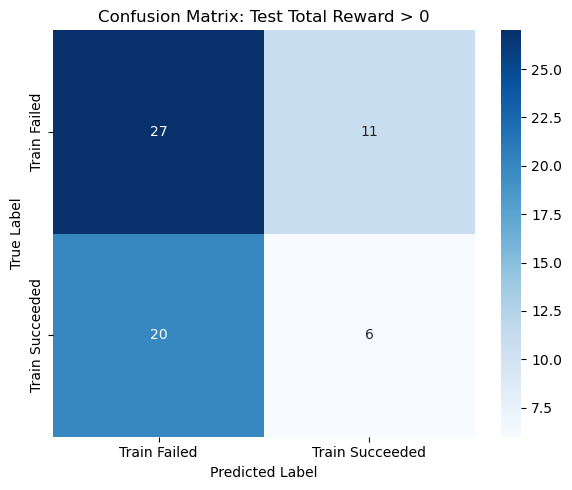

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Provided confusion matrix

# Labels
labels = ["Train Failed", "Train Succeeded"]

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: Test Total Reward > 0")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
ccccccc

In [59]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

def add_curriculum_and_predictability_features(meta_df):
    # Separate train and test feature sets
    train_cols = [col for col in meta_df.columns if col.startswith("train_") and meta_df[col].dtype != "object"]
    test_cols = [col.replace("train_", "test_") for col in train_cols if col.replace("train_", "test_") in meta_df.columns]
    
    train_features = meta_df[train_cols].values
    test_features = meta_df[test_cols].values

    # Standardize before distance calculations
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_features)
    test_scaled = scaler.transform(test_features)

    # 1. Curriculum Similarity Features
    cos_sim = np.einsum('ij,ij->i', train_scaled, test_scaled) / (
        np.linalg.norm(train_scaled, axis=1) * np.linalg.norm(test_scaled, axis=1))
    euclidean_dist = np.linalg.norm(train_scaled - test_scaled, axis=1)

    meta_df["sim_cosine"] = cos_sim
    meta_df["dist_euclidean"] = euclidean_dist

    # 2. Predictability Score (from residual diagnostics)
    predictability_cols = [c for c in meta_df.columns if c.startswith("train_resid_") or c.startswith("train_ljung_")]
    scaler_pred = StandardScaler()
    pred_features = scaler_pred.fit_transform(meta_df[predictability_cols])
    predictability_score = pred_features.mean(axis=1)

    meta_df["predictability_score"] = predictability_score

    return meta_df

In [66]:
meta_df = eb.completed_runs_df.copy()
meta_df = meta_df.replace([np.inf, -np.inf], np.nan)
meta_df.dropna(inplace=True)
expanded_df = add_curriculum_and_predictability_features(meta_df)
expanded_df

,run_hash,seed,target_date,agent,policy,env_version,train_episode_id,test_episode_id,total_timesteps,ticker,...,test_sharpe,test_sortino,test_calmar,test_market_sharpe,test_market_sortino,test_market_calmar,transferability,sim_cosine,dist_euclidean,predictability_score
0,1f70679c91b861f1c4b3f7eb2521751d,314,2024-01-01,PPO,MlpPolicy,v2,1353,1354,50000,AAPL,...,-0.011223,-0.014447,-0.101900,-0.120560,-0.204950,-0.474026,2.909602,0.016490,6.894097,-0.297664
1,774c2c75203b1a935c76360b43b584b1,314,2024-02-01,PPO,MlpPolicy,v2,1355,1356,50000,AAPL,...,0.023039,0.051292,0.202812,-0.075627,-0.114769,-0.429958,2.361333,0.635460,3.890219,0.041645
2,1234a46d1402c0b1750b723e6abfe8b4,314,2024-03-01,PPO,MlpPolicy,v2,1357,1358,50000,AAPL,...,-0.079752,-0.089895,-0.619497,0.064092,0.119952,0.581565,4.286212,0.185389,15.542978,0.016656
3,1851e35145a13506db4cb58f8ec70443,314,2024-04-01,PPO,MlpPolicy,v2,1359,1360,50000,AAPL,...,0.097208,0.165474,0.728261,0.195595,0.483023,2.102164,1.836156,-0.127818,18.045833,0.117387
4,c16a6ebc6ee2e2323b97673c5d17c2a4,314,2024-05-01,PPO,MlpPolicy,v2,1361,1362,50000,AAPL,...,0.118643,1.475050,1.444472,0.349171,1.035599,6.264705,4.191242,-0.170081,41.657002,0.036141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,dcd94ee5aa1a7769dd58853a7be177cd,314,2024-11-01,PPO,MlpPolicy,v2,2003,2004,50000,XOM,...,-0.215153,-0.197383,-0.623042,-0.117110,-0.173858,-0.432399,3.839000,-0.298015,8.792328,-0.132506
326,9386f45f868e689b284aa7203ebbf4ca,314,2024-12-01,PPO,MlpPolicy,v2,2005,2006,50000,XOM,...,-0.052174,-0.062561,-0.364871,-0.141791,-0.193372,-0.850891,2.361892,0.063078,8.058535,-0.047118
327,05e763500976a1728c38efe14b32418f,314,2025-01-01,PPO,MlpPolicy,v2,2007,2008,50000,XOM,...,0.066095,0.063965,0.558890,0.064552,0.092634,0.667151,3.408355,0.103224,13.165016,-0.057686
328,22bae358c503f2fc2974c9053bca8a00,314,2025-02-01,PPO,MlpPolicy,v2,2009,2010,50000,XOM,...,-0.034773,-0.027699,-0.402064,-0.023506,-0.026366,-0.206698,3.004530,-0.029636,16.262319,-0.129891


In [96]:
edf = expanded_df.copy()
edf["transferability"].describe()

count    315.000000
mean       3.279320
std        6.991036
min      -62.189241
25%        2.223282
50%        3.216317
75%        4.374087
max       70.490041
Name: transferability, dtype: float64

In [105]:
from scipy.stats import pointbiserialr

# Step 1: Define binary target from transferability
edf["target"] = (edf["test_total_reward"] > 0.1).astype(int)

# Step 2: Check correlation of new features with binary target
features_to_test = ["predictability_score", "sim_cosine", "dist_euclidean"]
correlation_results = {}

for feat in features_to_test:
    corr, pval = pointbiserialr(edf["target"], edf[feat])
    correlation_results[feat] = {"correlation": corr, "p_value": pval}

# Format to DataFrame
correlation_df = pd.DataFrame.from_dict(correlation_results, orient="index").reset_index()
correlation_df.columns = ["feature", "correlation", "p_value"]

import ace_tools_open as tools; tools.display_dataframe_to_user(name="Meta-Feature Correlation with Transferability", dataframe=correlation_df)


Meta-Feature Correlation with Transferability


Loading ITables v2.4.0 from the internet... (need help?)


In [106]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_rolling_similarity(df, feature_prefix="train_", window=5):
    # Extract features from the training side only
    train_cols = [col for col in df.columns if col.startswith(feature_prefix) and df[col].dtype in [np.float64, np.int64]]
    train_data = df[train_cols].values

    # Normalize feature vectors
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_data)

    # Compute similarity of each episode to the mean of the previous N episodes
    rolling_sim = []
    for i in range(len(train_scaled)):
        if i < window:
            rolling_sim.append(np.nan)  # Not enough history
        else:
            ref_vector = train_scaled[i]
            history_avg = train_scaled[i - window:i].mean(axis=0)
            sim = cosine_similarity([ref_vector], [history_avg])[0, 0]
            rolling_sim.append(sim)

    df["rolling_sim_past"] = rolling_sim
    return df

# Apply to edf
edf_rolled = compute_rolling_similarity(edf, window=5)
tools.display_dataframe_to_user(name="EDF with Rolling Similarity", dataframe=edf_rolled[["target_date", "rolling_sim_past", "target"]].tail(10))


EDF with Rolling Similarity


Loading ITables v2.4.0 from the internet... (need help?)


In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Prepare features and labels

feature_cols = [col for col in edf.columns if col not in [
    "target_date", "run_hash", "ticker", "env_version", "agent", "policy",
    "train_episode_id", "test_episode_id", "target", "transferability","dist_euclidean","sim_cosine","predictability_score"
]and 'test_' not in col]

X = edf.dropna()[feature_cols]

# Keep only numeric columns (float or int)
X = X.select_dtypes(include=["number"])
y = edf.dropna()["target"]
#print(len(X),len(y),X.columns)
feature_cols = X.columns.tolist()
# Handle any remaining NaNs
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Train-test split for stability
X_train, X_val, y_train, y_val = train_test_split(X_imputed, y, test_size=0.3, random_state=42, stratify=y)

# Train RandomForestClassifier
rf = RandomForestClassifier(n_estimators=250, random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values(by="importance", ascending=False).reset_index(drop=True)
importance_df

,feature,importance
0,train_resid_oracle_median,0.055458
1,rolling_sim_past,0.050550
2,train_sharpe,0.045304
3,train_resid_market_mean,0.042815
4,train_resid_market_max,0.042137
5,train_ljung_oracle_pval,0.041576
6,train_calmar,0.040982
7,train_sortino,0.039198
8,train_resid_oracle_acf1,0.038225
9,train_market_sortino,0.038136


In [108]:
# Correlation of the new rolling similarity feature with transferability
from scipy.stats import pointbiserialr

corr, pval = pointbiserialr(edf_rolled.dropna()["target"], edf_rolled.dropna()["rolling_sim_past"])
rolling_sim_corr_df = pd.DataFrame({
    "feature": ["rolling_sim_past"],
    "correlation": [corr],
    "p_value": [pval]
})

# Check where it ranks in feature importance if we train a model with only safe features
safe_features_extended = [
    col for col in edf_rolled.columns
    if col.startswith("train_") or col == "rolling_sim_past"
]

X_safe_ext = edf_rolled[safe_features_extended].dropna()
y_safe_ext = edf_rolled.loc[X_safe_ext.index, "target"]

X_safe_imputed = imputer.fit_transform(X_safe_ext)

# Train-test split
X_train_ext, X_val_ext, y_train_ext, y_val_ext = train_test_split(
    X_safe_imputed, y_safe_ext, test_size=0.3, random_state=42, stratify=y_safe_ext)

# Train RandomForest
rf_ext = RandomForestClassifier(n_estimators=250, random_state=42)
rf_ext.fit(X_train_ext, y_train_ext)

importances_ext = rf_ext.feature_importances_
importance_df_ext = pd.DataFrame({
    "feature": safe_features_extended,
    "importance": importances_ext
}).sort_values(by="importance", ascending=False).reset_index(drop=True)

tools.display_dataframe_to_user(name="Rolling Similarity Correlation & Importance", dataframe=rolling_sim_corr_df), tools.display_dataframe_to_user(name="RF Feature Importance (with rolling_sim_past)", dataframe=importance_df_ext.head(20))


Rolling Similarity Correlation & Importance


Loading ITables v2.4.0 from the internet... (need help?)


RF Feature Importance (with rolling_sim_past)


Loading ITables v2.4.0 from the internet... (need help?)


(None, None)

In [101]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
importance_df_dropped = importance_df.copy()
# Use top N features (we'll go with top 10)
top_n = 20
top_features = importance_df_dropped["feature"].head(top_n).tolist()

X_top = X[top_features]
X_top_imputed = imputer.fit_transform(X_top)

# Train-test split
X_train_top, X_val_top, y_train_top, y_val_top = train_test_split(
    X_top_imputed, y, test_size=0.4, random_state=42, stratify=y)

# Train RandomForest with top features
rf_top = RandomForestClassifier(n_estimators=250, random_state=42,class_weight='balanced')
rf_top.fit(X_train_top, y_train_top)

# Predict
y_pred = rf_top.predict(X_val_top)
y_proba = rf_top.predict_proba(X_val_top)[:, 1]

# Evaluate
report = classification_report(y_val_top, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_val_top, y_pred)
accuracy = accuracy_score(y_val_top, y_pred)

report_df = pd.DataFrame(report).T
report_df["accuracy"] = accuracy
conf_matrix_df = pd.DataFrame(conf_matrix, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])

tools.display_dataframe_to_user(name="Transferability Classifier Report", dataframe=report_df.round(3))
tools.display_dataframe_to_user(name="Confusion Matrix", dataframe=conf_matrix_df)


Transferability Classifier Report


Loading ITables v2.4.0 from the internet... (need help?)


Confusion Matrix


Loading ITables v2.4.0 from the internet... (need help?)


In [102]:
edf['target'].value_counts()

target
1    158
0    157
Name: count, dtype: int64

In [103]:
# Load and Prepare Data ================
ohlcv_df = OHLCV_DF.copy()


# Filter Tickers ======================
tickers = ohlcv_df['symbol'].unique()
tickers = tickers[~np.isin(tickers, excluded_tickers)]
tickers = ["AAPL"]  # Force test with AAPL
#tickers = TOP2_STOCK_BY_SECTOR
# Load and prepare trackers
ep_tracker    = EpisodeTracker()
env_tracker   = EnvironmentTracker()
agent_tracker = AgentTracker()

In [119]:
ep = ep_tracker.findEpisode("2025-01-01","AAPL",120,"both")
train_df = ep['train']['df']

env = env_tracker.findEnvironment(
    "v4",
    {"lookback":0,
     "scaling_strategy":"auto",
     "n_timesteps":120,
     "market_features":[ "close", "price_change", "volume_change"]},
    ticker="AAPL",
    start_idx=ep['train']['df_start_iloc']
)
agent = agent_tracker.findAgent('PPO','MlpPolicy',{})

In [120]:
ep['train']
model = agent["model"].boot(env['environment'])
model

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [121]:
model.learn(total_timesteps=10_000)
#env['environment'].reset()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119      |
|    ep_rew_mean     | -0.55    |
| time/              |          |
|    fps             | 755      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 119         |
|    ep_rew_mean          | 0.135       |
| time/                   |             |
|    fps                  | 583         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006211591 |
|    clip_fraction        | 0.0377      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.683      |
|    explained_variance   | -0.306      |
|    learning_rate        | 0.

In [122]:
env

{'env_id': 20,
 'id': 20,
 'version': 'v4',
 'config': {'lookback': 0,
  'market_features': ['close', 'price_change', 'volume_change'],
  'n_timesteps': 120,
  'scaling_strategy': 'auto',
  'ticker': 'AAPL',
  'start_idx': 631},
 'environment': <environments.PositionTradingEnvV4 at 0x26e9fae8b50>}

In [123]:
#runs = eb.run()
train_df = ep['train']['df']
eb.extract_agent_diagnostics(env['environment'],model)

{'train_total_reward': 1.967881947512105,
 'train_wallet': 1.2931760419047569,
 'train_market': 1.2610675191320353,
 'train_resid_oracle_std': 0.16494287256017917,
 'train_resid_oracle_skew': 7.103799480869331,
 'train_resid_oracle_kurtosis': 71.34820007224745,
 'train_resid_oracle_acf1': -0.05321011982612267,
 'train_resid_oracle_mean': -5.614202191824159e-05,
 'train_resid_oracle_median': -0.0005808469933746441,
 'train_resid_oracle_max': 1.5933017925434414,
 'train_resid_oracle_min': -0.4093191124298554,
 'train_ljung_oracle_pval': 0.4848610801053723,
 'train_resid_market_std': 0.015775389029011783,
 'train_resid_market_skew': -0.3210630665793414,
 'train_resid_market_kurtosis': -0.7958548432718517,
 'train_resid_market_acf1': 0.914043804030199,
 'train_resid_market_mean': 0.011380011926499397,
 'train_resid_market_median': 0.01859754449302642,
 'train_resid_market_max': 0.04772539437014056,
 'train_resid_market_min': -0.02246761205961101,
 'train_ljung_market_pval': 9.9892055947559

In [124]:
"""
# V4 AutoScaler =================================

# V4 ============================================
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119      |
|    ep_rew_mean     | -0.293   |
| time/              |          |
|    fps             | 368      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 119          |
|    ep_rew_mean          | -0.227       |
| time/                   |              |
|    fps                  | 375          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0039481735 |
|    clip_fraction        | 0.00503      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.69        |
|    explained_variance   | -0.107       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.146        |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00425     |
|    value_loss           | 0.253        |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 119         |
|    ep_rew_mean          | -0.0435     |
| time/                   |             |
|    fps                  | 344         |
|    iterations           | 3           |
|    time_elapsed         | 17          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.004291957 |
|    clip_fraction        | 0.00679     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.688      |
|    explained_variance   | 0.169       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0454     |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00449    |
|    value_loss           | 0.221       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 119         |
|    ep_rew_mean          | 0.179       |
| time/                   |             |
|    fps                  | 353         |
|    iterations           | 4           |
|    time_elapsed         | 23          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.008619598 |
|    clip_fraction        | 0.0177      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.684      |
|    explained_variance   | 0.14        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0335     |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00589    |
|    value_loss           | 0.206       |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 119          |
|    ep_rew_mean          | 0.386        |
| time/                   |              |
|    fps                  | 353          |
|    iterations           | 5            |
|    time_elapsed         | 28           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0033814711 |
|    clip_fraction        | 0.0268       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.679       |
|    explained_variance   | 0.103        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.68e-05     |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00903     |
|    value_loss           | 0.169        |
------------------------------------------

{'train_total_reward': 1.8404246654035108,
 'train_wallet': 1.2311124381229703,
 'train_market': 1.2610675191320353,
 'train_resid_oracle_std': 0.1649787826127421,
 'train_resid_oracle_skew': 7.100542170671588,
 'train_resid_oracle_kurtosis': 71.28572593394061,
 'train_resid_oracle_acf1': -0.03614584193924006,
 'train_resid_oracle_mean': -6.761922913547766e-05,
 'train_resid_oracle_median': -0.0005808469933746441,
 'train_resid_oracle_max': 1.5933017925434414,
 'train_resid_oracle_min': -0.4090312514457644,
 'train_ljung_oracle_pval': 0.43397976725966475,
 'train_resid_market_std': 0.004207810947213421,
 'train_resid_market_skew': 3.914946935632663,
 'train_resid_market_kurtosis': 19.557611931096172,
 'train_resid_market_acf1': 0.6085714183637173,
 'train_resid_market_mean': -0.004342682837053663,
 'train_resid_market_median': -0.006046241177076084,
 'train_resid_market_max': 0.022354143814353078,
 'train_resid_market_min': -0.006476324087659302,
 'train_ljung_market_pval': 4.222512971005281e-58,
 'train_sharpe': 0.09010650230498658,
 'train_sortino': 0.32005405023559785,
 'train_calmar': 1.8007265566029227,
 'train_market_sharpe': 0.09126171812151522,
 'train_market_sortino': 0.32781071367581516,
 'train_market_calmar': 1.8345812189354533}
<stable_baselines3.ppo.ppo.PPO at 0x18822e54a90>
"""

"\n# V4 AutoScaler =================================\n\n# V4 ============================================\n---------------------------------\n| rollout/           |          |\n|    ep_len_mean     | 119      |\n|    ep_rew_mean     | -0.293   |\n| time/              |          |\n|    fps             | 368      |\n|    iterations      | 1        |\n|    time_elapsed    | 5        |\n|    total_timesteps | 2048     |\n---------------------------------\n------------------------------------------\n| rollout/                |              |\n|    ep_len_mean          | 119          |\n|    ep_rew_mean          | -0.227       |\n| time/                   |              |\n|    fps                  | 375          |\n|    iterations           | 2            |\n|    time_elapsed         | 10           |\n|    total_timesteps      | 4096         |\n| train/                  |              |\n|    approx_kl            | 0.0039481735 |\n|    clip_fraction        | 0.00503      |\n|    clip_range

In [14]:
xxxx

NameError: name 'xxxx' is not defined

In [ ]:
pddf= pd.DataFrame(runs)
pddf['train_episode_id'],pddf['test_episode_id']

In [ ]:
cols_to_drop = [col for col in pddf.columns if col.startswith('test_') and col != 'test_total_reward']
pddf_cleaned = pddf.drop(columns=cols_to_drop)

# Now you can compute correlation
correlations = pddf_cleaned.corr(numeric_only=True)['test_total_reward'].sort_values(ascending=False)
correlations

In [ ]:
pddf[['train_wallet','test_wallet','train_market','test_market','test_total_reward',"train_total_reward",
"train_sortino"                  ,
"train_calmar"                   ,
"train_resid_market_acf1"        ,
"train_resid_oracle_kurtosis"    ,
"train_sharpe"                   ,
"train_resid_oracle_max"         ]]

In [ ]:
ppdf['train_episode_id']